In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = 'C:\\Users\\Soonju\\Desktop\Aiffel\\Ex4_Stock\\005930.KS.csv'
df = pd.read_csv(dataset_filepath) 
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-05-18,47950.0,49100.0,47600.0,48800.0,46788.835938,20481981
1,2020-05-19,50100.0,50500.0,49700.0,50300.0,48227.015625,25168295
2,2020-05-20,50000.0,50200.0,49800.0,50000.0,47939.382813,14896899
3,2020-05-21,50300.0,50400.0,49850.0,49950.0,47891.437500,14949266
4,2020-05-22,49600.0,49800.0,48600.0,48750.0,46740.894531,19706284


- 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
- 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있습니다.
- 우리는 종가(Close)만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)

# STEP 1 : 시계열 데이터 준비

In [2]:
# Date 인덱스로 빼고, Close 열만 뽑기
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']
print(type(ts))  # Series 확인
ts.head()


<class 'pandas.core.series.Series'>


Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

# STEP 2 : 각종 전처리 수행


(결측치처리, 로그변환)

In [3]:
# 결측치 처리
ts.isnull().sum()

# 있으면 .fillna(0)

0

In [4]:
# lms방법
ts = ts.interpolate(method='time')
ts[ts.isna()] 

Series([], Name: Close, dtype: float64)

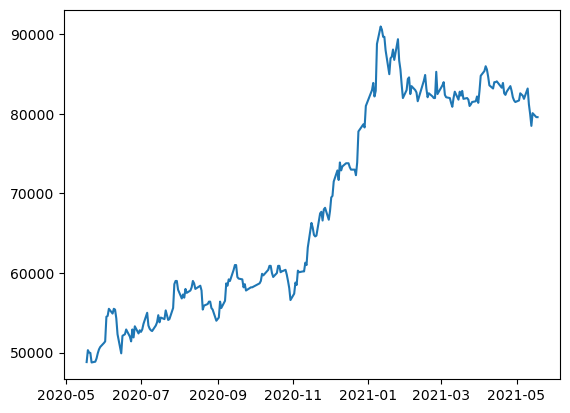

In [5]:
plt.plot(ts)

In [6]:
ts_log = np.log(ts)

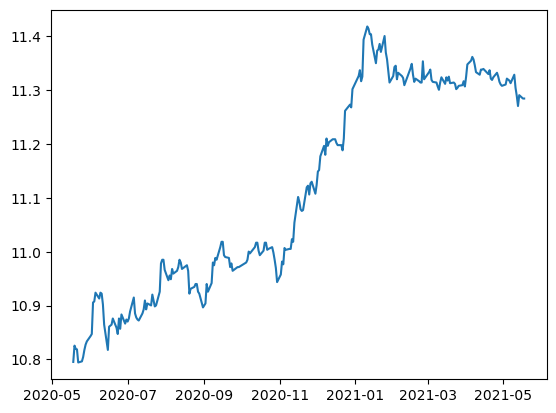

In [7]:
plt.plot(ts_log)

# STEP 3 : 시계열 안정성 분석
- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

In [8]:
# 시계열을 하려면, 세가지 (이동평균, 이동표준편차, 자기공분산) 이 일정해야함
# 이것을 함께 보여주는 그래프를 그려보는 함수
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [9]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

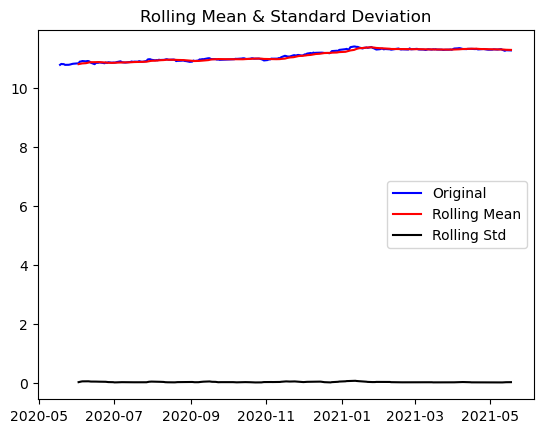

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


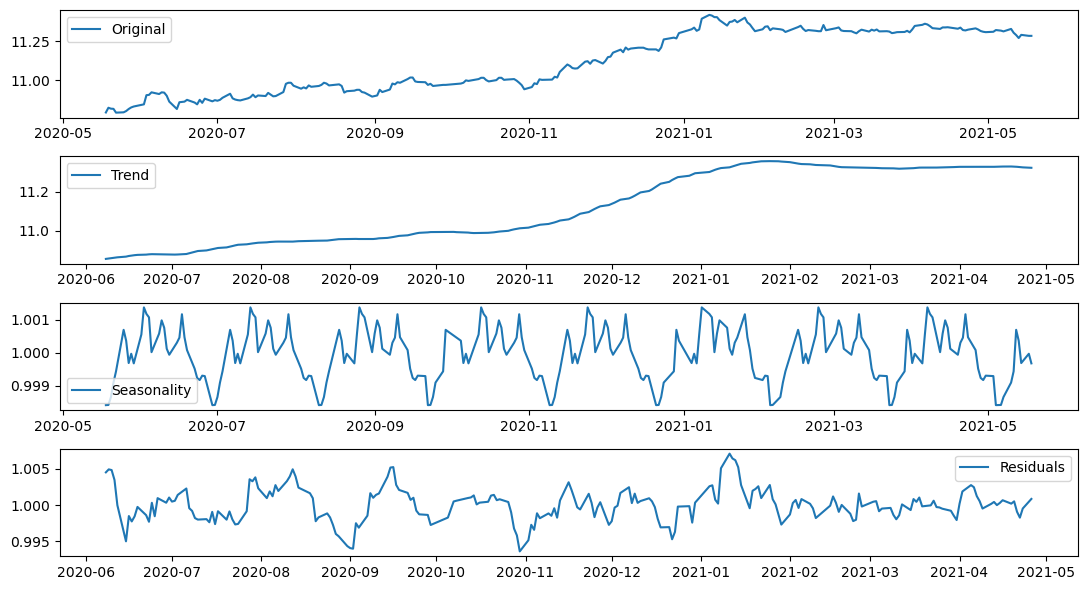

In [10]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)  # p-value :  0.59

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 
trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 ) 추출
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화) 추출
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성 빼주기


plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [11]:
# Residual 안정성 확인

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)  # p-value =  6.234854e-08

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


# STEP 4 : 학습, 테스트 데이터셋 생성

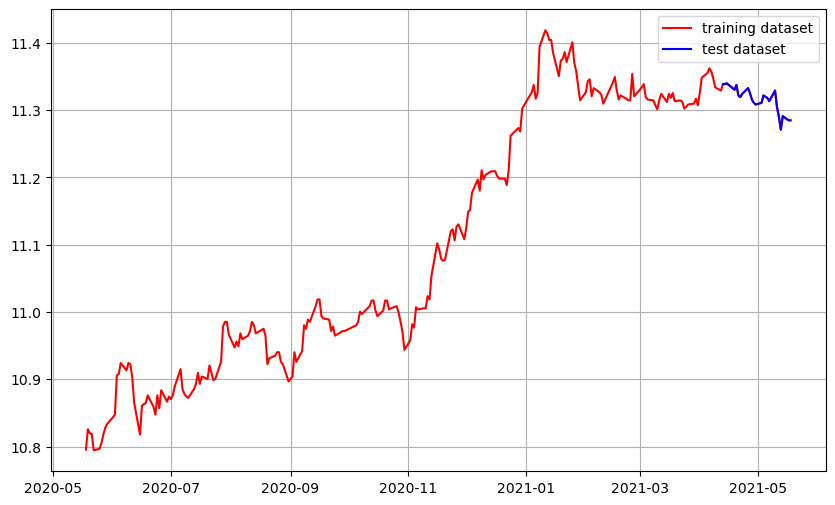

In [12]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

# STEP 5 : 적정 ARIMA 모수 찾기
- ACF, PACF 그려보기 -> p,q 구하기
- 차분 안정성 확인 -> d 구하기

C:\Users\Soonju\anaconda3\envs\tf270\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


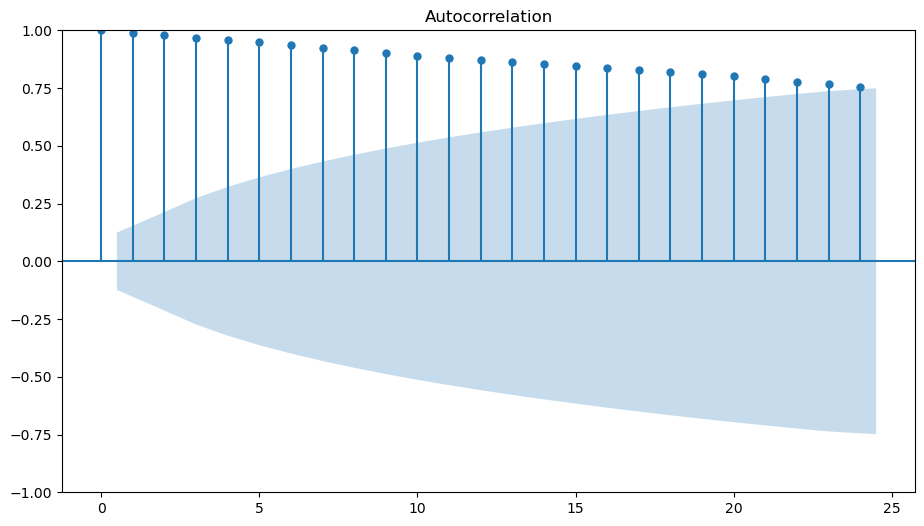

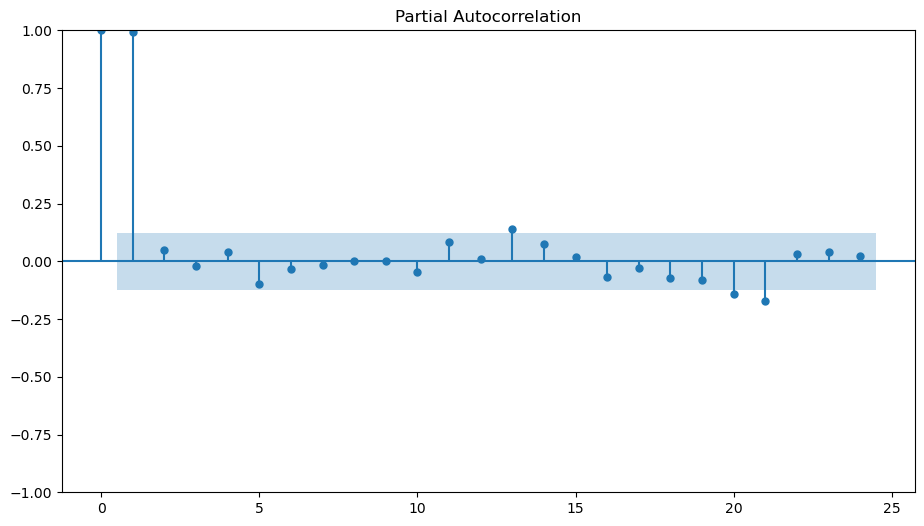

In [13]:
# statsmodels에서 제공하는 ACF와 PACF 플로팅 기능을 사용하여 parameter p,d,q 정하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   
# ACF : Autocorrelation (자기상관계수) 그래프 그리기 
# x:상관계수, y:시차수
# AR(p)에서는 점차적으로 감소하고, MA(q) 이후에 0이 되므로 q를 결정할 수 있음.

plot_pacf(ts_log)  
# PACF : Partial Autocorrelation (부분적 자기상관계수) 그래프 그리기
# AR(p)에서는 0이 되고, MA(q) 에서는 감소하므로, p를 결정할 수 있음.
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


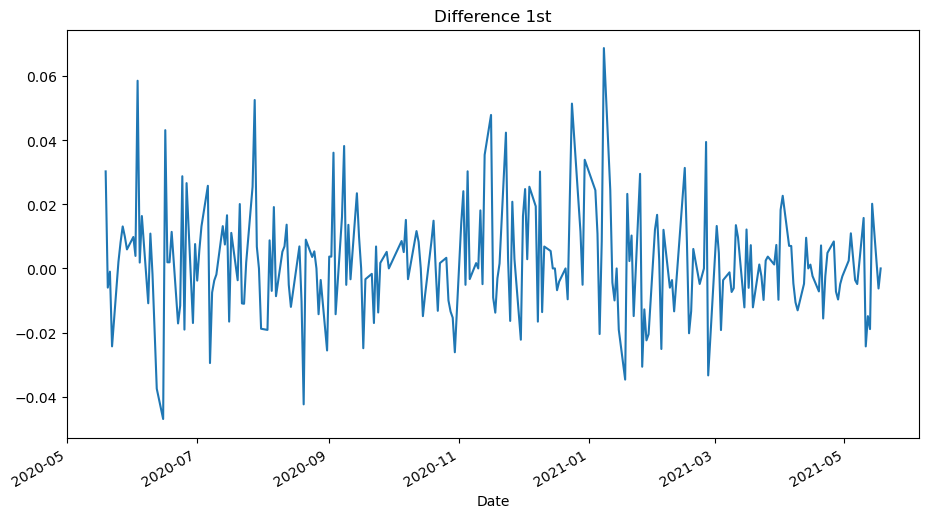

In [14]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

In [15]:
# p=2, d=1, q=0

# STEP 6 : ARIMA 모델 훈련과 테스트
- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

C:\Users\Soonju\anaconda3\envs\tf270\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Soonju\anaconda3\envs\tf270\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Soonju\anaconda3\envs\tf270\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Soonju\anaconda3\envs\tf270\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning

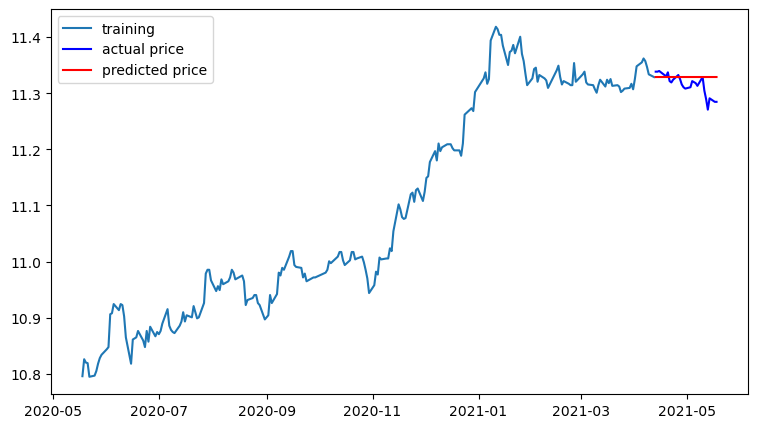

In [16]:
from statsmodels.tsa.arima.model import ARIMA
# ARIMA model fit 하기 
model = ARIMA(train_data, order=(2, 1, 0))  # p값을 2로 테스트
fitted_m1 = model.fit() 

# Forecast : 결과가 fc에 담깁니다. 
fc= fitted_m1.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  3514270.6899914467
MAE:  1409.0883239153616
RMSE:  1874.6388158766601
MAPE: 1.74%


C:\Users\Soonju\anaconda3\envs\tf270\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Soonju\anaconda3\envs\tf270\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Soonju\anaconda3\envs\tf270\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Soonju\anaconda3\envs\tf270\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning

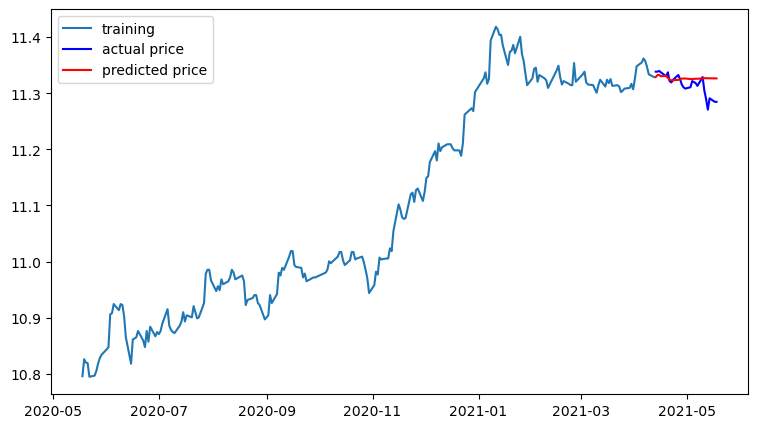

In [18]:
from statsmodels.tsa.arima.model import ARIMA
# ARIMA model fit 하기 
model = ARIMA(train_data, order=(14, 1, 0))  # p값을 2로 테스트
fitted_m1 = model.fit() 

# Forecast : 결과가 fc에 담깁니다. 
fc= fitted_m1.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  3002641.2051399057
MAE:  1233.362536813612
RMSE:  1732.8130900763376
MAPE: 1.53%


# 회고

ARIMA 모델이 들어가면서부터 이해가 어려웠다. 특히 pqr을 산출하는 부분이 이해가 힘들었다.   
대체 p,q,r은 어떻게 결정이 난다는 걸까.  
p와 q 중 하나가 0이 된다고 이해했는데, 마지막 lms 예제에서 갑자기 p=14가 되면서부터 너무 혼란스러웠다.  

게다가 MAPE는 10% 이하일지 모르겠지만  
마지막 시각화 그래프상으로는 이건 예측에 쓸 수 없을 듯한 결과치처럼 보인다.  
실제값에 너무 못따라가는 것 같다.  

따라가게 하려고 p,q,r을 이리저리 다 돌려봤지만  
그래프가 갑자기 밑으로 꺾이거나, 위로 솟구치거나, 일직선이 되는 경우가 많았고,  
구불구불하게 따라가는 모양이 나오는 것 자체가 힘들었다.  

이렇게 계속하다가는 답이 없을 듯 하여 자료를 찾아보다가  
그래서 여러가지 자료를 찾아보다가 youtube에 https://www.youtube.com/watch?v=gqryqIlvEoM 가 조금 이해되는 듯 해서 참고하기로 했다.  
그 분은 갑자기 떨어지는 그 부분에서부터 살짝 튀어오르는 값을 유의미하다고 보고 해당 숫자를 변수로 넣고 있어서 나도 따라했다.  

하지만 이마저도 첫번째 유의미한 수로 넣어도 나오질 않아서 그 뒤로도 튀어오르는 여러 값을 넣어 계속 해봤다. 
유의미하다는 의미가 퇴색되는 듯 했다.  

실습 3개 종목은 배운대로 하니 MAPE가 10% 이하로 금방 떨어졌지만,  
이 또한 과연 실질적으로 쓸 수 있을지 의문이 들 정도로 빨간색 그래프가 파란색 그래프를 따라가질 못했다.  

p,q,r을 정확히 알아내는 것이 관건인 듯 한데, 아직 뚜렷한 방법을 찾지 못했다.  
